In [15]:
# Import libraries and modules
import numpy as np
np.random.seed(123)  # for reproducibility
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten, TimeDistributed, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras import metrics
from keras import backend

%matplotlib inline

In [16]:
# Define the performance metrics of rmse, sensitivity, recall, specificity, and precision

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis = -1))

def sensitivity(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     sensitivity = tp / (tp + fn)
     return sensitivity

# Recall is the same as the sensitivity
def recall(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     recall = tp / (tp + fn)
     return recall

def specificity(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     specificity = tn / (tn + fp)
     return specificity


def precision(y_true, y_pred):  
     y_pred_pos = backend.round(backend.clip(y_pred, 0, 1))
     y_pred_neg = 1 - y_pred_pos
     y_pos = backend.round(backend.clip(y_true, 0, 1))
     y_neg = 1 - y_pos
     tp = backend.sum(y_pos * y_pred_pos)
     tn = backend.sum(y_neg * y_pred_neg)
     fp = backend.sum(y_neg * y_pred_pos)
     fn = backend.sum(y_pos * y_pred_neg)
     precision = tp / (tp + fp)
     return precision

In [17]:
#import data 
# data=pd.read_csv('/home/ramyh/Documents/ClassDeepLearning/EEGdata.csv', names=['f1':'f2049'])
data=pd.read_csv('/home/ramyh/Documents/ClassDeepLearning/EEGData_3Classes_NoisyWhite_SNR-15.csv') # dataset including 1000 samples from each class

In [18]:
data["f4097"].value_counts()

1    1000
2    1000
0    1000
Name: f4097, dtype: int64

In [19]:
# shuffle the data
data=data.iloc[np.random.permutation(len(data))]

In [20]:
# reset the data index
data=data.reset_index(drop=True)

In [21]:
# Time Steps of LSTM
data_length = 4096
timesteps = 2048
data_dim = data_length//timesteps
data_dim

2

In [22]:
# training data
X_train=data.loc[0:2399,data.columns != 'f4097']
# training data.reshape
# X_train=X_train.values.reshape([X_train.shape[0], -1, 1])
# X_train=X_train.values.reshape([X_train.shape[0], 64, 64])
X_train=X_train.values.reshape([X_train.shape[0], timesteps, data_dim])

temp=data['f4097']
y_train=temp[0:2400]
# map data into arrays
y_train=np_utils.to_categorical(y_train, num_classes=3)

# test data
X_test=data.loc[2400:2999,data.columns != 'f4097']

# test data.reshape
# X_test = X_test.values.reshape([X_test.shape[0], -1, 1])
# X_test = X_test.values.reshape([X_test.shape[0], 64, 64])
X_test = X_test.values.reshape([X_test.shape[0], timesteps, data_dim])

y_test=temp[2400:3000]
# map data into arrays
y_test=np_utils.to_categorical(y_test, num_classes=3)

# https://elitedatascience.com/keras-tutorial-deep-learning-in-python
# https://faroit.github.io/keras-docs/0.3.3/examples/
# https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/

In [23]:
X_test.shape

(600, 2048, 2)

In [24]:
# create the model
model = Sequential()
# model.add(LSTM(100, input_shape= (4096, 1)))
# model.add(LSTM(100, input_shape= (64, 64)))
# model.add(Dropout(0.1, input_shape= (timesteps, data_dim)))
# model.add(LSTM(100, return_sequences = True))

model.add(LSTM(100, input_shape= (timesteps, data_dim), return_sequences = True))
# model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(50)))
# model.add(GlobalMaxPooling1D())
model.add(GlobalAveragePooling1D())
# model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[sensitivity, specificity, 'accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=40)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2048, 100)         41200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2048, 50)          5050      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 46,403
Trainable params: 46,403
Non-trainable params: 0
_________________________________________________________________
None
Train on 2400 samples, validate on 600 samples
Epoch 1/40
2400/2400 [==============================] - 241s - loss: 1.0332 - sensitivity: 0.0267 - specificity: 0.9992 - acc: 0.4833 - val_loss: 0.8829 - val_sensitivity: 0.1500 - val_specificity: 0.9958 - val_acc: 0.

2400/2400 [==============================] - 249s - loss: 0.4070 - sensitivity: 0.7946 - specificity: 0.8975 - acc: 0.7950 - val_loss: 0.4573 - val_sensitivity: 0.6833 - val_specificity: 0.8425 - val_acc: 0.6850
Epoch 34/40
2400/2400 [==============================] - 249s - loss: 0.4080 - sensitivity: 0.7900 - specificity: 0.8952 - acc: 0.7900 - val_loss: 0.3951 - val_sensitivity: 0.7950 - val_specificity: 0.8975 - val_acc: 0.7950
Epoch 35/40
2400/2400 [==============================] - 247s - loss: 0.4002 - sensitivity: 0.7929 - specificity: 0.8973 - acc: 0.7942 - val_loss: 0.4141 - val_sensitivity: 0.7733 - val_specificity: 0.8883 - val_acc: 0.7750
Epoch 36/40
2400/2400 [==============================] - 253s - loss: 0.4107 - sensitivity: 0.7908 - specificity: 0.8969 - acc: 0.7925 - val_loss: 0.3913 - val_sensitivity: 0.8000 - val_specificity: 0.9008 - val_acc: 0.8017
Epoch 37/40
2400/2400 [==============================] - 246s - loss: 0.3944 - sensitivity: 0.7975 - specificity: 0.

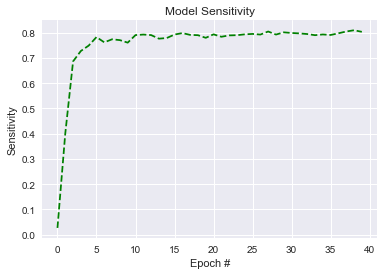

In [25]:
# Plot the sensitivity along with epochs
plt.plot(history.history['sensitivity'], 'g--')
plt.title('Model Sensitivity')
plt.ylabel('Sensitivity')
plt.xlabel('Epoch #')
plt.show()

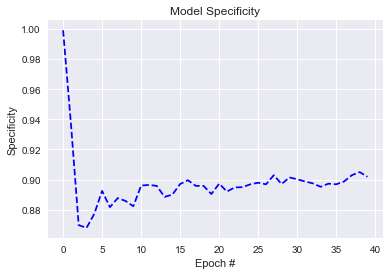

In [26]:
# Plot the specificity along with epochs
plt.plot(history.history['specificity'], 'b--')
plt.title('Model Specificity')
plt.ylabel('Specificity')
plt.xlabel('Epoch #')
plt.show()

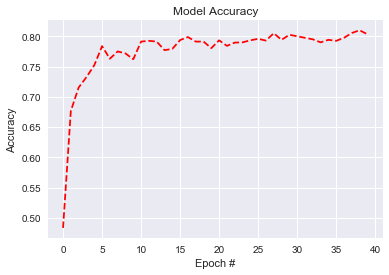

In [27]:
# Plot the classification accuracy along with epochs
plt.plot(history.history['acc'], 'r--')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.show()

In [28]:
# evaluate the classification accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("Sensitivity = %.2f%%" % (scores[1]*100))
print("Specificity = %.2f%%" % (scores[2]*100))
print("Classification Accuracy = %.2f%%" % (scores[3]*100))

Sensitivity = 79.83%
Specificity = 90.00%
Classification Accuracy = 80.00%
